In [201]:
import os
from collections import Counter
from typing import Counter as CounterType, Dict, List, Tuple

import torch
from nltk.tokenize import word_tokenize
from tqdm import tqdm

import matplotlib.pyplot as plt

### Preapre Data

#### Dataset

In [2]:
class IMDBDataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        path_to_data: str,
    ):
        super().__init__()

        self.path_to_data = path_to_data
        self.dataset = self._prepare_dataset(path_to_data)

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(
        self,
        idx: int,
    ) -> List[str]:
        return self.dataset[idx]

    @staticmethod
    def _prepare_dataset(path_to_data: str) -> List[List[str]]:
        dataset = []

        pos_dir = os.path.join(path_to_data, "pos")
        neg_dir = os.path.join(path_to_data, "neg")
        
        for dir in [pos_dir, neg_dir]:
            for filename in tqdm(
                os.listdir(dir),
                desc="parse txt files",
            ):
                if not filename.endswith(".txt"):
                    continue
                with open(os.path.join(dir, filename), mode="r") as fp:
                    review = fp.read()
                    dataset.append(word_tokenize(review.lower()))
        return dataset

In [3]:
train_dataset = IMDBDataset(path_to_data="data/aclImdb/train")
test_dataset = IMDBDataset(path_to_data="data/aclImdb/test")

100%|██████████| 12500/12500 [00:38<00:00, 328.76it/s]


In [4]:
train_dataset[0]

['for',
 'a',
 'movie',
 'that',
 'gets',
 'no',
 'respect',
 'there',
 'sure',
 'are',
 'a',
 'lot',
 'of',
 'memorable',
 'quotes',
 'listed',
 'for',
 'this',
 'gem',
 '.',
 'imagine',
 'a',
 'movie',
 'where',
 'joe',
 'piscopo',
 'is',
 'actually',
 'funny',
 '!',
 'maureen',
 'stapleton',
 'is',
 'a',
 'scene',
 'stealer',
 '.',
 'the',
 'moroni',
 'character',
 'is',
 'an',
 'absolute',
 'scream',
 '.',
 'watch',
 'for',
 'alan',
 '``',
 'the',
 'skipper',
 "''",
 'hale',
 'jr.',
 'as',
 'a',
 'police',
 'sgt',
 '.']

#### Analysis

In [5]:
train_dataset_len_distr = [len(review) for review in train_dataset]
test_dataset_len_distr = [len(review) for review in test_dataset]

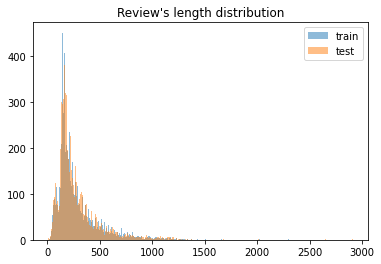

In [6]:
plt.hist(
    train_dataset_len_distr,
    bins=len(set(train_dataset_len_distr)),
    alpha=0.5,
    label="train",
)
plt.hist(
    test_dataset_len_distr,
    bins=len(set(test_dataset_len_distr)),
    alpha=0.5,
    label="test",
)
plt.legend()
plt.title("Review's length distribution");

In [7]:
train_dataset_n_digits_distr = Counter([len(str(length)) for length in train_dataset_len_distr])
train_dataset_n_digits_distr.most_common()

[(3, 22482), (2, 2132), (4, 386)]

In [8]:
test_dataset_n_digits_distr = Counter([len(str(length)) for length in test_dataset_len_distr])
test_dataset_n_digits_distr.most_common()

[(3, 22372), (2, 2262), (4, 363), (1, 3)]

#### Collator

In [9]:
tokens_counter = Counter()

for review in train_dataset:
    tokens_counter.update(review)

In [10]:
len(tokens_counter), tokens_counter.most_common(5)

(111836,
 [('the', 334840),
  (',', 275887),
  ('.', 234757),
  ('and', 163477),
  ('a', 162292)])

In [170]:
class Token2Idx:
    
    def __init__(
        self,
        tokens_counter: CounterType,
        min_df: int,
    ):
        self.tokens_counter = tokens_counter
        self.min_df = min_df

        self.token2idx = self._prepare_token2idx(
            tokens_counter=tokens_counter,
            min_df=min_df,
        )
    
    def __call__(
        self,
        seq: List[str],
    ) -> torch.LongTensor:
        return [self.token2idx.get(token, self.token2idx["<unk>"]) for token in seq]
    
    def __getitem__(self, key: str) -> int:
        return self.token2idx[key]

    @staticmethod
    def _prepare_token2idx(
        tokens_counter: CounterType,
        min_df: int,
    ) -> Dict[str, int]:
        token2idx = {
            "<bos>": 0,
            "<eos>": 1,
            "<unk>": 2,
            "<pad>": 3,
        }

        for token, cnt in tqdm(
            tokens_counter.most_common(),
            desc="loop over unique tokens",
        ):
            if token in token2idx:
                continue
            if cnt < min_df:
                continue

            token2idx[token] = len(token2idx)
        
        return token2idx

In [171]:
token2idx = Token2Idx(
    tokens_counter=tokens_counter,
    min_df=5,
)

loop over unique tokens: 100%|██████████| 111836/111836 [00:00<00:00, 1272351.97it/s]


In [172]:
len(token2idx.token2idx)

31577

In [173]:
token2idx(train_dataset[0])

[24,
 8,
 26,
 20,
 225,
 73,
 1174,
 53,
 263,
 37,
 8,
 190,
 9,
 901,
 4357,
 3517,
 24,
 19,
 1520,
 6,
 828,
 8,
 26,
 134,
 874,
 14565,
 11,
 177,
 182,
 43,
 7162,
 15090,
 11,
 8,
 156,
 18872,
 6,
 4,
 2,
 124,
 11,
 48,
 1512,
 2013,
 6,
 125,
 24,
 1526,
 35,
 4,
 18873,
 34,
 8602,
 2130,
 23,
 8,
 565,
 6964,
 6]

In [174]:
for dataset in [train_dataset, test_dataset]:
    for review in tqdm(
        dataset,
        desc="assertion loop",
    ):
        assert len(review) == len(token2idx(review))

assertion loop: 100%|██████████| 25000/25000 [00:03<00:00, 8208.12it/s]


In [175]:
class Collator:

    def __init__(
        self,
        token2idx: Token2Idx,
    ):
        self.token2idx = token2idx
    
    def __call__(
        self,
        batch: List[List[str]],
    ) -> torch.LongTensor:
        tensor_seq = []
        tensor_inv_seq = []
        for seq in batch:
            tokenized_seq = self.token2idx(seq)
            tensor_seq.append(torch.LongTensor(tokenized_seq))

            tokenized_inv_seq = [self.token2idx["<bos>"]] + tokenized_seq[::-1] + [self.token2idx["<eos>"]]
            tensor_inv_seq.append(torch.LongTensor(tokenized_inv_seq))

        padded_sequences =  torch.nn.utils.rnn.pad_sequence(
            sequences=tensor_seq,
            batch_first=True,
            padding_value=self.token2idx["<pad>"],
        )
        padded_inv_sequences =  torch.nn.utils.rnn.pad_sequence(
            sequences=tensor_inv_seq,
            batch_first=True,
            padding_value=self.token2idx["<pad>"],
        )
        return padded_sequences, padded_inv_sequences

In [176]:
collator = Collator(token2idx=token2idx)

#### DataLoader

In [177]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=2,  # TODO
    shuffle=True,
    num_workers=0,
    collate_fn=collator,
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collator,
)

In [180]:
seq, inv_seq = next(iter(train_dataloader))
seq.shape, inv_seq.shape

(torch.Size([2, 243]), torch.Size([2, 245]))

In [181]:
seq, inv_seq = next(iter(test_dataloader))
seq.shape, inv_seq.shape

(torch.Size([1, 283]), torch.Size([1, 285]))

### Seq2Seq LSTM

In [182]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [183]:
def number_of_parameters(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

In [348]:
class Seq2SeqLSTM(torch.nn.Module):
    
    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        encoder_hidden_size: int,
        encoder_num_layers: int,  # TODO: fix if > 1
        encoder_dropout: float,
        encoder_bidirectional: bool,
        decoder_num_layers: int,  # TODO: fix if > 1
        decoder_dropout: float,
    ):
        super().__init__()
        self.embedding = torch.nn.Embedding(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_dim,
            padding_idx=token2idx["<pad>"], # TODO: remove hardcode

        )
        self.encoder = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=encoder_hidden_size,
            num_layers=encoder_num_layers,
            dropout=encoder_dropout,
            bidirectional=encoder_bidirectional,
            batch_first=True,
        )
        decoder_hidden_size = encoder_hidden_size * (2 if encoder_bidirectional else 1)
        self.decoder = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=decoder_hidden_size,
            num_layers=decoder_num_layers,
            dropout=decoder_dropout,
            bidirectional=False,
            batch_first=True,
        )
        self.head = torch.nn.Linear(
            in_features=decoder_hidden_size,
            out_features=num_embeddings,
        )
    
    def forward(
        self,
        seq: torch.LongTensor,
        inv_seq: torch.LongTensor,
    ):
        emb = self._embed(seq)
        encoder_output, _ = self.encoder(emb)
        skip_thoughts = self._get_skip_thoughts(encoder_output=encoder_output)

        inv_emb = self._embed(inv_seq)
        decoder_output, _ = self.decoder(inv_emb, (skip_thoughts, skip_thoughts))

        decoder_output, _ = self._pad_packed_sequence(sequence=decoder_output)
        logits = self.head(decoder_output)
        return logits
    
    def _embed(
        self,
        seq: torch.LongTensor,
    ) -> torch.nn.utils.rnn.PackedSequence:
        emb = self.embedding(seq)
        lengths = (seq != token2idx["<pad>"]).sum(dim=1) # TODO: remove hardcode
        return torch.nn.utils.rnn.pack_padded_sequence(
            input=emb, lengths=lengths,
            batch_first=True, enforce_sorted=False,
        )
    
    @staticmethod
    def _pad_packed_sequence(
        sequence: torch.nn.utils.rnn.PackedSequence,
    ) -> Tuple[torch.Tensor, torch.LongTensor]:
        return torch.nn.utils.rnn.pad_packed_sequence(
            sequence=sequence,
            batch_first=True,
            padding_value=token2idx["<pad>"], # TODO: remove hardcode
        )

    @staticmethod
    def _get_skip_thoughts(
        encoder_output: torch.nn.utils.rnn.PackedSequence,
    ) -> torch.Tensor:
        encoder_output, lengths = Seq2SeqLSTM._pad_packed_sequence(sequence=encoder_output)
        return torch.index_select(
            input=encoder_output,
            dim=1,
            index=lengths - 1,
        ).mean(dim=1).unsqueeze(dim=0)

In [349]:
model = Seq2SeqLSTM(
    num_embeddings=len(token2idx.token2idx),
    embedding_dim=100,
    encoder_hidden_size=128,
    encoder_num_layers=1,
    encoder_dropout=0,  # num_layers = 1
    encoder_bidirectional=True,
    decoder_num_layers=1,
    decoder_dropout=0,  # num_layers = 1
)

In [350]:
number_of_parameters(model)

11875101

In [351]:
model(*next(iter(train_dataloader))).shape

torch.Size([2, 181, 31577])